In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import os
import matplotlib.pyplot as plt

# **Load Data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path to your Google Drive folder containing images
drive_folder_path = '/content/drive/MyDrive/Deep Learning/Image_set'

# List to store image paths and corresponding output labels
image_paths = []
output_labels = []

# Traverse the Google Drive folder and collect image paths and assign output labels
for foldername, subfolders, filenames in os.walk(drive_folder_path):
    for filename in filenames:
        # Check if the file is an image (you can add more extensions if necessary)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            image_path = os.path.join(foldername, filename)
            image_paths.append(image_path)
            # Check for keywords in the filename and assign output labels accordingly
            if 'hamza' in filename.lower():
                output_labels.append('Hamza Ahmad')
            elif 'subhan' in filename.lower():
                output_labels.append('Subhan Wasif')
            else:
                output_labels.append('Unknown')

# Create a DataFrame from image paths and corresponding output labels
df = pd.DataFrame({'Image Path': image_paths, 'Output': output_labels})

# Print the DataFrame
print(df)


                                            Image Path        Output
0    /content/drive/MyDrive/Deep Learning/Image_set...       Unknown
1    /content/drive/MyDrive/Deep Learning/Image_set...       Unknown
2    /content/drive/MyDrive/Deep Learning/Image_set...       Unknown
3    /content/drive/MyDrive/Deep Learning/Image_set...       Unknown
4    /content/drive/MyDrive/Deep Learning/Image_set...       Unknown
..                                                 ...           ...
145  /content/drive/MyDrive/Deep Learning/Image_set...  Subhan Wasif
146  /content/drive/MyDrive/Deep Learning/Image_set...  Subhan Wasif
147  /content/drive/MyDrive/Deep Learning/Image_set...  Subhan Wasif
148  /content/drive/MyDrive/Deep Learning/Image_set...  Subhan Wasif
149  /content/drive/MyDrive/Deep Learning/Image_set...  Subhan Wasif

[150 rows x 2 columns]


In [4]:
# Randomly sample 10 images for testing
test_df = df.sample(n=10, random_state=42)

# Remove these images from the original DataFrame to create the training set
train_df = df.drop(test_df.index)

In [5]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [6]:
train_df.head(10)

,Image Path,Output
0,/content/drive/MyDrive/Deep Learning/Image_set...,Unknown
1,/content/drive/MyDrive/Deep Learning/Image_set...,Unknown
2,/content/drive/MyDrive/Deep Learning/Image_set...,Unknown
3,/content/drive/MyDrive/Deep Learning/Image_set...,Unknown
4,/content/drive/MyDrive/Deep Learning/Image_set...,Unknown
5,/content/drive/MyDrive/Deep Learning/Image_set...,Unknown
6,/content/drive/MyDrive/Deep Learning/Image_set...,Unknown
7,/content/drive/MyDrive/Deep Learning/Image_set...,Unknown
8,/content/drive/MyDrive/Deep Learning/Image_set...,Unknown
9,/content/drive/MyDrive/Deep Learning/Image_set...,Unknown


# **Train AutoEncoder**

In [7]:
# Function to load and preprocess images
def preprocess_image(file_path, target_size=(256, 256)):
    img = load_img(file_path, target_size=target_size)
    img = img_to_array(img)
    img = img / 255.0
    return img

In [8]:
# Load and preprocess images
train_image_paths = train_df.iloc[:, 0].values
train_images = np.array([preprocess_image(path) for path in image_paths])

In [9]:
train_images.shape

(150, 256, 256, 3)

In [10]:
# Autoencoder Model
input_img = Input(shape=(256,256,3))

In [11]:
# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoder_output')(x)

In [12]:
# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [13]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [14]:
# Fit the autoencoder
autoencoder.fit(train_images, train_images, epochs=100, batch_size=32, shuffle=True)

Epoch 1/100
5/5 [==============================] - 17s 485ms/step - loss: 0.0780
Epoch 2/100
5/5 [==============================] - 1s 103ms/step - loss: 0.0725
Epoch 3/100
5/5 [==============================] - 1s 133ms/step - loss: 0.0646
Epoch 4/100
5/5 [==============================] - 1s 115ms/step - loss: 0.0519
Epoch 5/100
5/5 [==============================] - 1s 112ms/step - loss: 0.0402
Epoch 6/100
5/5 [==============================] - 1s 106ms/step - loss: 0.0344
Epoch 7/100
5/5 [==============================] - 0s 97ms/step - loss: 0.0312
Epoch 8/100
5/5 [==============================] - 0s 97ms/step - loss: 0.0264
Epoch 9/100
5/5 [==============================] - 0s 95ms/step - loss: 0.0227
Epoch 10/100
5/5 [==============================] - 0s 100ms/step - loss: 0.0203
Epoch 11/100
5/5 [==============================] - 0s 97ms/step - loss: 0.0185
Epoch 12/100
5/5 [==============================] - 0s 96ms/step - loss: 0.0172
Epoch 13/100
5/5 [=======================

In [15]:
# After training the autoencoder
encoder_output = autoencoder.get_layer('encoder_output').output
encoder_model = Model(inputs=autoencoder.input, outputs=encoder_output)

In [16]:
# Extract and save latent representations
encoded_train_imgs = encoder_model.predict(train_images)

5/5 [==============================] - 0s 12ms/step


In [17]:
# Save latent representations
with open('latent_representations.pkl', 'wb') as f:
    pickle.dump(encoded_train_imgs, f)

# Save corresponding image names in a separate array
image_names = train_df['Image Path'].tolist()
with open('image_names.pkl', 'wb') as f:
    pickle.dump(image_names, f)

# **Display Most Similar Image**

In [67]:
# Selecting the first test image as an example
test_image_path = test_df['Image Path'].iloc[1]
test_image = preprocess_image(test_image_path)
test_image = test_image.reshape(1, 256, 256, 3)

In [68]:
print(test_image_path)

/content/drive/MyDrive/Deep Learning/Image_set/other (41).jpg


In [69]:
# Get latent representation for the test image
test_encoded = encoder_model.predict(test_image)

1/1 [==============================] - 0s 132ms/step


In [70]:
# Function to calculate cosine similarity

def calculate_cosine_similarity(test_encoded, train_encoded_imgs):
    return [cosine_similarity(test_encoded.reshape(1, -1), train_encoded.reshape(1, -1))[0][0] for train_encoded in train_encoded_imgs]

In [71]:
# Compute cosine similarity for the test image
similarities = calculate_cosine_similarity(test_encoded, encoded_train_imgs)
most_similar_index = np.argmax(similarities)
most_similar_image_path = image_names[most_similar_index]

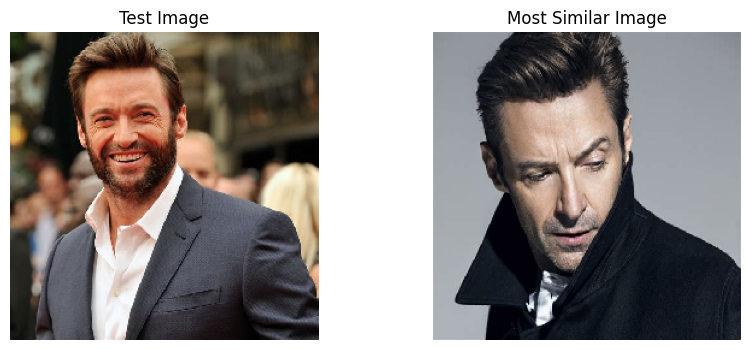

In [72]:
# Load the most similar image from its path
most_similar_image = preprocess_image(most_similar_image_path)

# Display the test image and the most similar image
plt.figure(figsize=(10, 4))

# Display test image
plt.subplot(1, 2, 1)
plt.imshow(test_image.reshape(256, 256, 3))
plt.title("Test Image")
plt.axis('off')

# Display most similar image
plt.subplot(1, 2, 2)
plt.imshow(most_similar_image)
plt.title("Most Similar Image")
plt.axis('off')

plt.show()
